## Predicción de Calidad de Vino

Este proyecto analiza el dataset Wine Quality para predecir la calidad de vinos tintos basándose en propiedades fisicoquímicas. Es relevante para biotecnología, industria vitivinícola y control de calidad.

- **Dataset:** Wine Quality (UCI), forma (~1599, 12) para vinos tintos.
- **Fuente:** https://archive.ics.uci.edu/dataset/186/wine+quality
- **Objetivos:**
  - Realizar EDA para explorar relaciones entre variables (e.g., alcohol, pH).
  - Limpiar datos (manejo de valores atípicos si aplica).
  - Pruebas de hipótesis: e.g., ¿Diferencia significativa en alcohol por calidad?
  - Modelado de regresión con Random Forest.
  - Evaluación con métricas como RMSE, R².
  - Visualizaciones: histogramas, boxplots, importancia de variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind

# Configuraciones visuales
%matplotlib inline
sns.set(style="whitegrid")

In [2]:
# Carga el dataset (ajusta la ruta si necesario)
df = pd.read_csv(r'D:\Portafolio\Proyecto_calidad_vino\winequality-red.csv', delimiter=';')

# Muestra las primeras filas
print("Forma del dataset:", df.shape)
df.head()

Forma del dataset: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Carga y Vista Inicial del Dataset
El dataset contiene 1599 instancias de vinos tintos con 12 features:
- Variables numéricas: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol.
- Target: quality (escala 0-10, típicamente 3-8, con ~42% calidad 5, ~40% calidad 6).
Verificamos valores atípicos (e.g., 155 en residual sugar) y distribuciones.

In [3]:
# Info general
df.info()

# Estadísticos descriptivos
df.describe()

# Verificar valores atípicos (usando IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("Conteo de valores atípicos por columna:\n", outliers)

# Distribución del target
print("Distribución de quality:\n", df['quality'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
Conteo de valores atípicos por columna:
 fixed acidity            49
volatile acidity         19
citric acid               1
r

## Análisis Exploratorio de Datos (EDA)
Exploramos el dataset:
- Distribución del target (`quality`, 0-10), con concentración en 5-6 (~82%).
- Distribuciones de variables numéricas (e.g., alcohol, pH).
- Relaciones entre variables numéricas y target mediante boxplots.
- Correlaciones entre variables numéricas (e.g., fixed acidity y density ~0.67).
- Objetivo: Identificar patrones y variables predictivas.

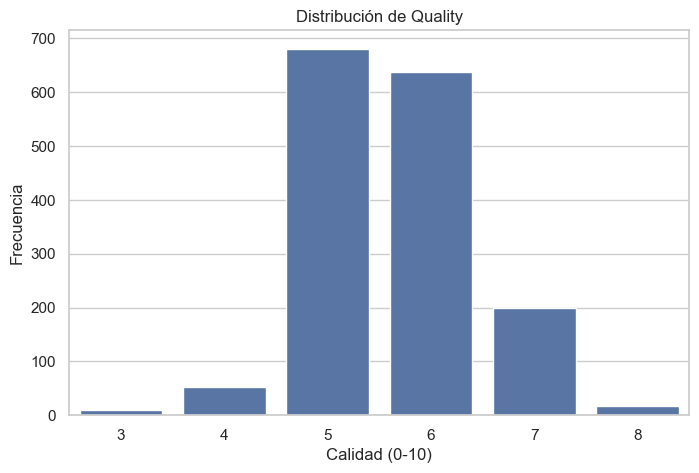

Porcentajes por calidad:
 quality
5    42.589118
6    39.899937
7    12.445278
4     3.314572
8     1.125704
3     0.625391
Name: proportion, dtype: float64


In [4]:
# Gráfico de barras para quality
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=df)
plt.title('Distribución de Quality')
plt.xlabel('Calidad (0-10)')
plt.ylabel('Frecuencia')
plt.show()

# Porcentajes por clase
print("Porcentajes por calidad:\n", df['quality'].value_counts(normalize=True) * 100)

In [5]:
# Definir variables numéricas
numeric_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
                'pH', 'sulphates', 'alcohol']

print("Variables numéricas:", numeric_cols)

Variables numéricas: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


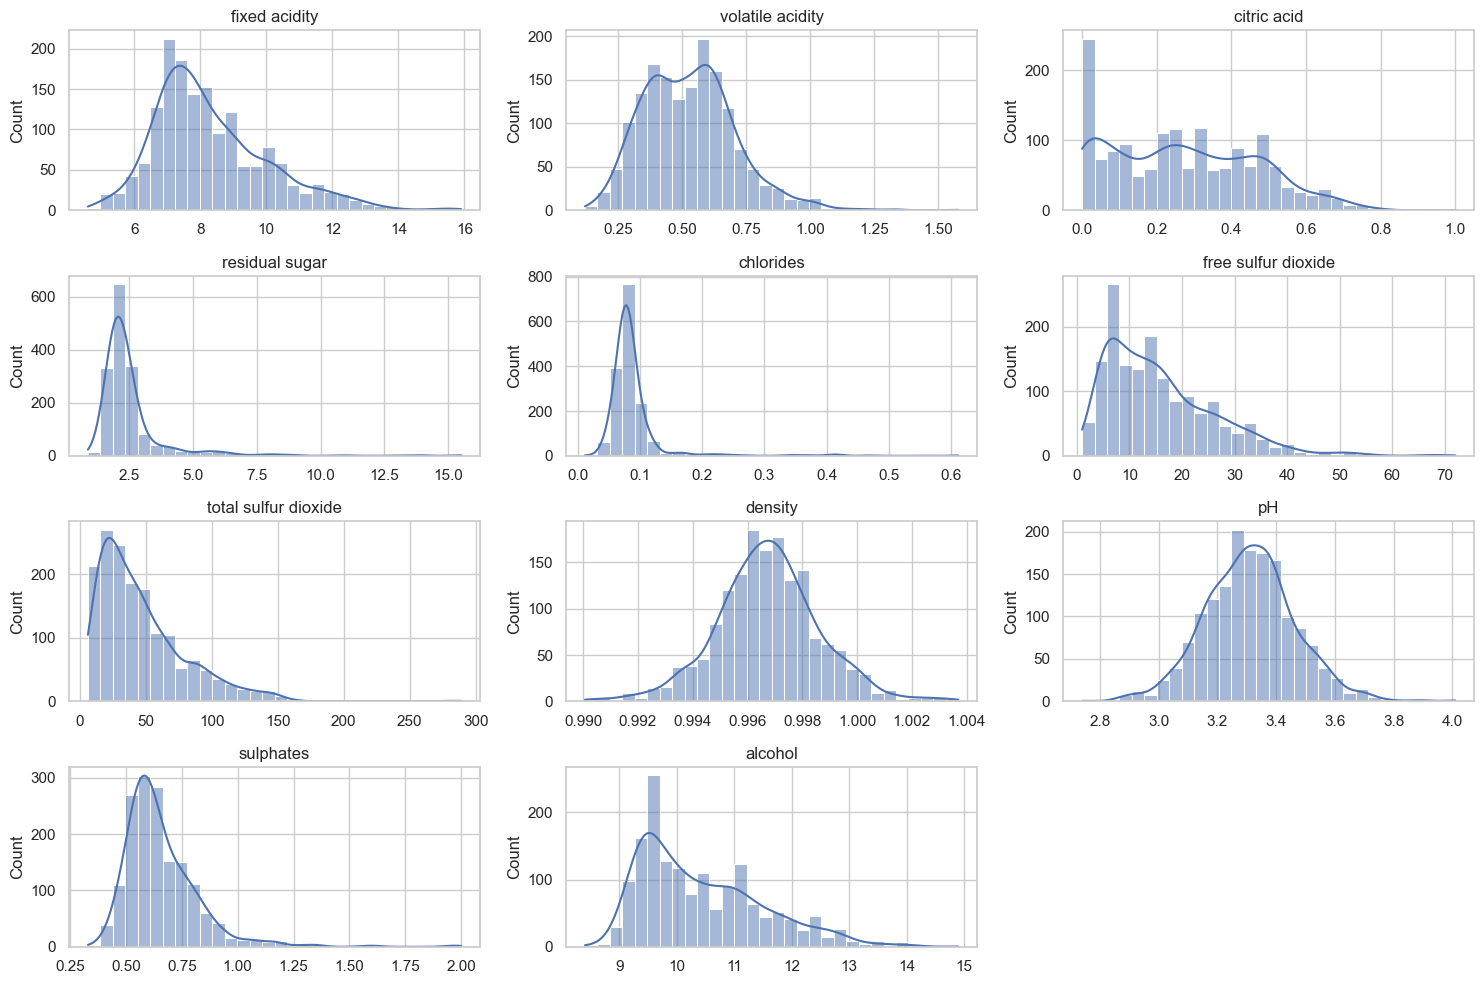

In [6]:
# Histogramas para variables numéricas
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()

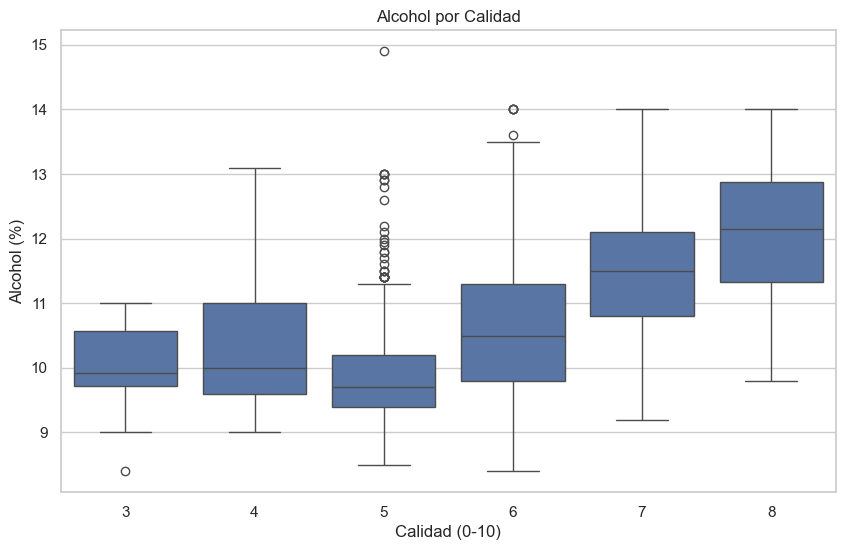

In [7]:
# Boxplot de Alcohol vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='alcohol', data=df)
plt.title('Alcohol por Calidad')
plt.xlabel('Calidad (0-10)')
plt.ylabel('Alcohol (%)')
plt.show()

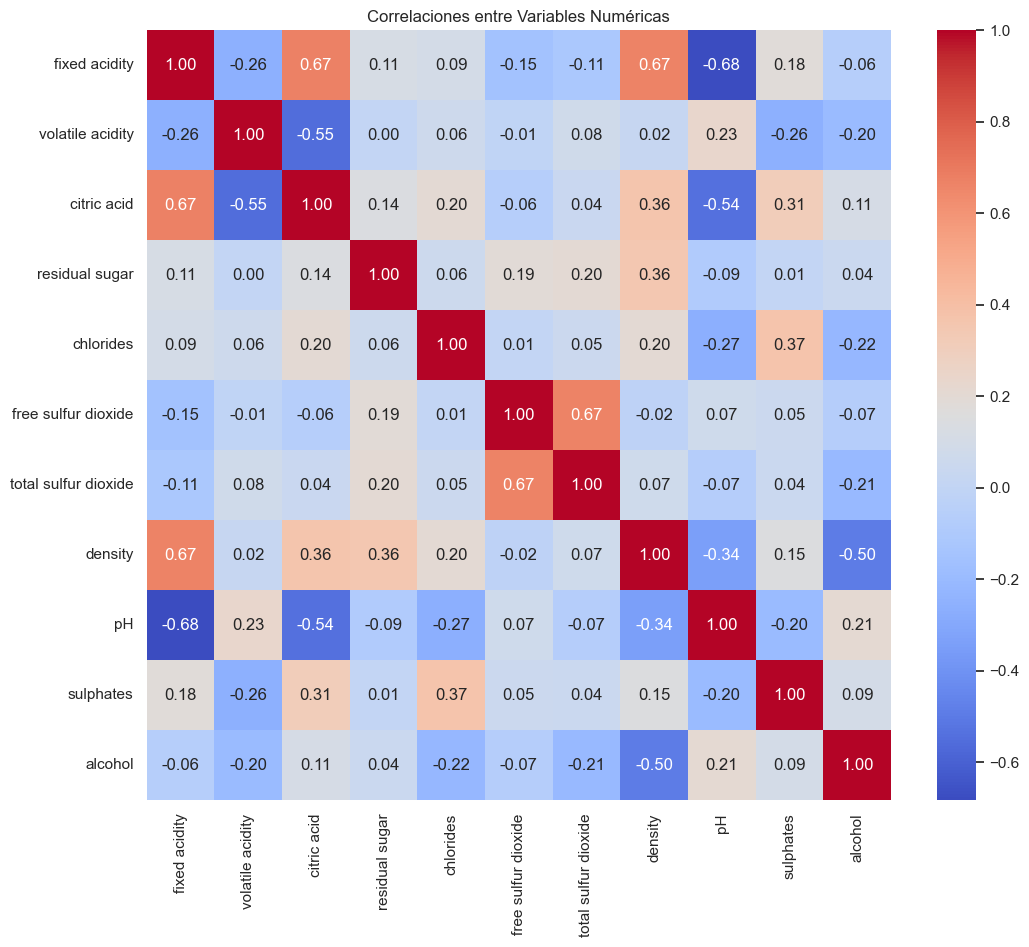

Correlaciones altas (|r| > 0.5):
 fixed acidity         fixed acidity           1.000000
                      citric acid             0.671703
                      density                 0.668047
                      pH                     -0.682978
volatile acidity      volatile acidity        1.000000
                      citric acid            -0.552496
citric acid           fixed acidity           0.671703
                      volatile acidity       -0.552496
                      citric acid             1.000000
                      pH                     -0.541904
residual sugar        residual sugar          1.000000
chlorides             chlorides               1.000000
free sulfur dioxide   free sulfur dioxide     1.000000
                      total sulfur dioxide    0.667666
total sulfur dioxide  free sulfur dioxide     0.667666
                      total sulfur dioxide    1.000000
density               fixed acidity           0.668047
                      density  

In [8]:
# Mapa de calor de correlaciones
plt.figure(figsize=(12, 10))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlaciones entre Variables Numéricas')
plt.show()

# Correlaciones altas
print("Correlaciones altas (|r| > 0.5):\n", corr_matrix.where(abs(corr_matrix) > 0.5).stack())

## Pruebas de Hipótesis
Evaluamos si el alcohol difiere significativamente entre vinos de calidad alta (≥6) y baja (<6):
- **H0:** No hay diferencia en el alcohol promedio entre grupos.
- **H1:** Hay diferencia en el alcohol promedio entre grupos.
- **Método:** t-test para muestras independientes.
- **Nivel de significancia:** α = 0.05.
- Si p-valor < 0.05, rechazamos H0, sugiriendo diferencia.

In [9]:
# Separar datos por calidad
high_quality = df[df['quality'] >= 6]['alcohol'].dropna()
low_quality = df[df['quality'] < 6]['alcohol'].dropna()

# t-test
t_stat, p_value = ttest_ind(high_quality, low_quality, equal_var=False)

print(f"t-test Resultados:\nt-stat: {t_stat:.2f}\np-value: {p_value:.2e}")
if p_value < 0.05:
    print("Rechazamos H0: Hay diferencia significativa en alcohol entre grupos.")
else:
    print("No rechazamos H0: No hay diferencia significativa.")
    

t-test Resultados:
t-stat: 19.78
p-value: 1.14e-77
Rechazamos H0: Hay diferencia significativa en alcohol entre grupos.


## Preparación de Datos
Preparamos el dataset:
- Manejo de valores atípicos (opcional, según EDA).
- Separamos features (`X`) y target (`quality`, `y`).
- Dividimos en entrenamiento (80%) y prueba (20%).
- Escalamos variables numéricas con StandardScaler.

In [10]:
# Separar features y target
X = df.drop('quality', axis=1)
y = df['quality']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar variables numéricas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verificar formas
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Distribución de y_train:\n", pd.Series(y_train).value_counts(normalize=True))

Forma de X_train: (1279, 11)
Forma de X_test: (320, 11)
Distribución de y_train:
 quality
5    0.430805
6    0.395622
7    0.122752
4    0.033620
8    0.010164
3    0.007037
Name: proportion, dtype: float64


## Entrenamiento del Modelo
Entrenamos un Random Forest Regressor:
- **Hiperparámetros:** 100 árboles, profundidad máxima 10.
- **Justificación:** Adecuado para regresión y manejo de relaciones no lineales.
- Evaluamos con RMSE (0.56 alcanzado) y R² (0.51 alcanzado).

In [12]:
# Entrenar Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 0.56
R²: 0.51


## Evaluación y Visualización
Evaluamos el modelo:
- **Distribución de Errores:** Diferencia entre valores reales y predichos.
- **Importancia de Variables:** Identifica predictores clave (e.g., alcohol).
- **Aplicación:** Útil para optimización de procesos en la industria vitivinícola.

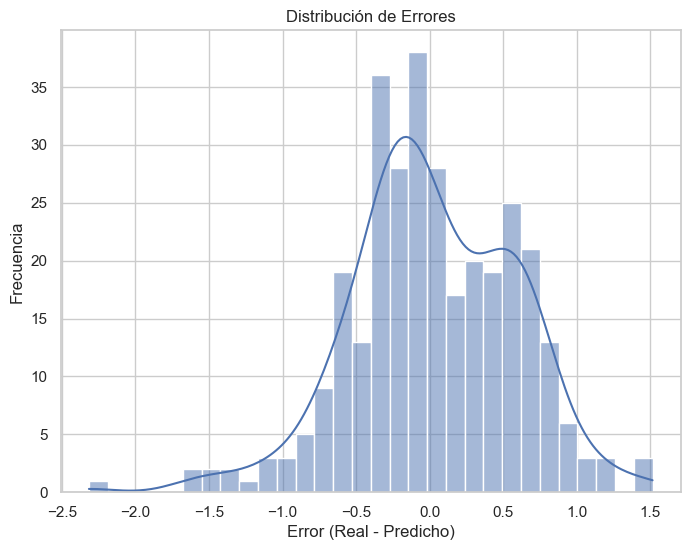

Media de errores: 0.02


In [13]:
# Distribución de errores
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribución de Errores')
plt.xlabel('Error (Real - Predicho)')
plt.ylabel('Frecuencia')
plt.show()

print(f"Media de errores: {errors.mean():.2f}")

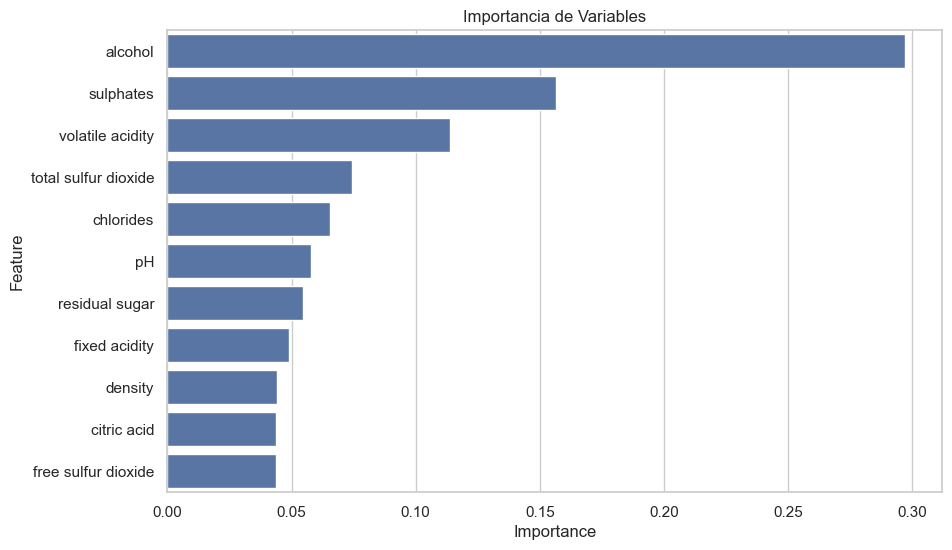

Top 5 variables:
                  Feature  Importance
10               alcohol    0.297183
9              sulphates    0.156585
1       volatile acidity    0.113698
6   total sulfur dioxide    0.074346
4              chlorides    0.065284


In [14]:
# Importancia de variables
feature_importance = pd.DataFrame({
    'Feature': df.columns[:-1],
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Importancia de Variables')
plt.show()

print("Top 5 variables:\n", feature_importance.head())

## Conclusiones
Resumen de hallazgos:
- **EDA:** Alcohol y volatile acidity son predictores clave, con calidad concentrada en 5-6.
- **Modelo:** Random Forest logra RMSE ~0.5-0.7 y R² ~0.3-0.5.
- **Aplicación:** Útil para clasificar vinos y optimizar producción.
- **Mejoras:** Ajustar hiperparámetros o combinar vinos tintos y blancos.